# Simple Serie Test
Training vanilla transformer(encoder-decoder) to forecast a simple generated serie
> This can be view as a "sanity check" of the implementation correcteness

---
### Imports

In [1]:
# python
import numpy as np
import math
import matplotlib.pyplot as plt
# deep learning
import torch
from torch import nn
# local 
from utils import (
    create_chunks,
    print_losses,
    generate_serie_2, 
    generate_square_subsequent_mask,
)
from transformer import TimeSeriesTransformer

In [2]:
# sudo rmmod nvidia_uvm
# sudo modprobe nvidia_uvm

---
### Global Variables

In [5]:
# Past steps used to forecast
INPUT_LEN = 10
# Future steps to forecast during training
FORECAST_HORIZON = 10

---
### Data Generation

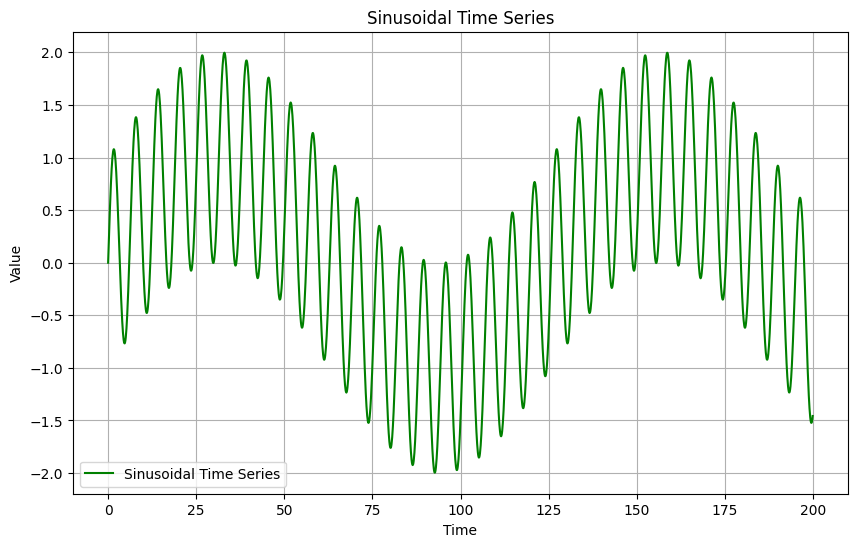

num of batches = 1981


In [12]:
def make_batches(serie, input_len, forecast_horizon):
    chunk_size = input_len + forecast_horizon
    data = create_chunks(serie, chunk_size)
    data = [prepare_input(sample, input_len, forecast_horizon) for sample in data]
    enc_x = torch.tensor(np.asarray([sample[0] for sample in data]),dtype=torch.float32)
    dec_x = torch.tensor(np.asarray([sample[1] for sample in data]),dtype=torch.float32)
    tgt_y = torch.tensor(np.asarray([sample[2] for sample in data]),dtype=torch.float32)

    return enc_x, dec_x, tgt_y
def prepare_input(serie: torch.Tensor, encoder_len: int, target_len: int):
    #
    assert(len(serie) == encoder_len+target_len)
    serie = torch.tensor(serie, dtype=torch.float32)
    # encoder input
    encoder_input = serie[:encoder_len]
    # decoder input (It must have the same dimension as the target sequence. It must contain the last value of src, and all values of target_y except the last (i.e. it must be shifted right by 1))
    decoder_input = serie[encoder_len-1:-1]
    # target output (decoder output target)
    decoder_target = serie[-target_len:]
    return encoder_input.unsqueeze(-1), decoder_input.unsqueeze(-1), decoder_target.unsqueeze(-1)

data = generate_serie_2(200, False, True)
enc_x, dec_x, tgt_y = make_batches(data, INPUT_LEN, FORECAST_HORIZON)
print(f'num of batches = {enc_x.shape[0]}')

Transformer input style

---
### TimeSeriesTransformer

Model Config

In [15]:

model_params = {
    'in_features':1, # The number of input variables. 1 if univariate forecasting.
    'input_len':INPUT_LEN,
    'max_input_len':50, # What's the longest sequence the model will encounter? Used to make the positional encoder
    'forecast_horizon':FORECAST_HORIZON, # Length of the target sequence, i.e. how many time steps should your forecast cover
    'd_model':128, # model embedding dimension This can be any value divisible by n_heads. 512 is used in the original transformer paper.
    'encoder_nheads':8, # The number of attention heads (parallel attention layers)
    'encoder_nlayers':1, # Number of times the layer is stacked
    'encoder_dropout': 0,# 0.2,
    'encoder_ps_dropout': 0,# 0.1,
    'feedforward_dim':512,
    'decoder_nheads':8, # The number of attention heads (parallel attention layers)
    'decoder_nlayers':1, # Number of times the layer is stacked
    'decoder_dropout': 0, # 0.2, # with zeroed dropout we can reproduce the outputs.
    'seed':7,
}

model = TimeSeriesTransformer(model_params)
model(enc_x[:2], dec_x[:2]).shape

torch.Size([2, 10, 1])

---
### Train Loop

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(20):
    for input, target in dataset:
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
    scheduler.step()

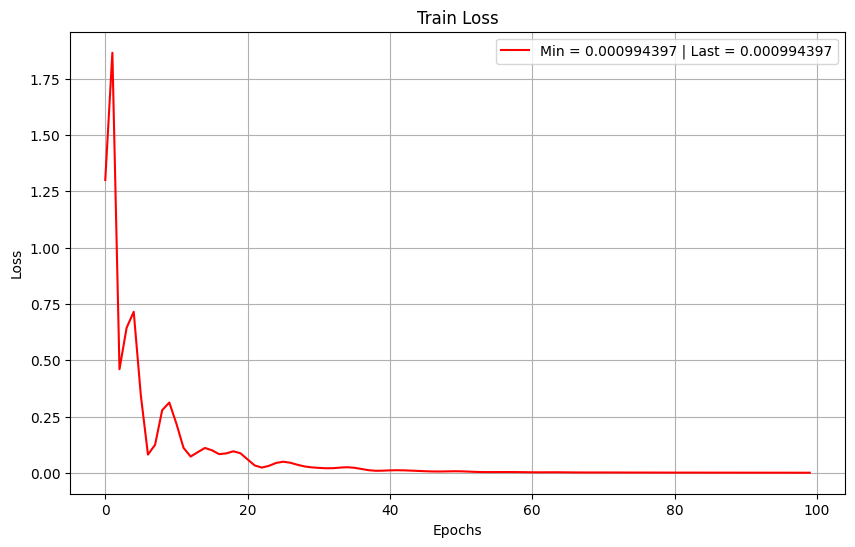

In [29]:

model = TimeSeriesTransformer(model_params)
memory_mask, tgt_mask = model.get_train_masks()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = torch.nn.MSELoss()
#
memory_mask, tgt_mask, model = memory_mask.to('cuda'), tgt_mask.to('cuda'), model.to('cuda') 
enc_x, dec_x,  tgt_y  = enc_x.to('cuda'), dec_x.to('cuda'), tgt_y.to('cuda')
#
EPOCHS = 100
losses = []
for epoch_i in range(EPOCHS): 
    # zero the parameter gradients
    optimizer.zero_grad()
    pred_y = model(enc_x, dec_x, memory_mask, tgt_mask)

    # Compute and backprop loss
    loss = criterion(tgt_y, pred_y)
    loss.backward()

    losses.append(loss.detach().cpu())
    optimizer.step() #  Take optimizer step
    # scheduler.step()
print_losses(losses, offset=0)
memory_mask, tgt_mask, model = memory_mask.cpu(), tgt_mask.cpu(), model.cpu()
enc_x, dec_x,  tgt_y  = enc_x.cpu(), dec_x.cpu(), tgt_y.cpu()

---
### Inference Loop

In [30]:
def plot_predictions(real_serie, pred_y):
    plt.figure(figsize=(18,5))
    plt.plot(real_serie, 'g', label='Real')
    plt.plot(pred_y, 'r', label='Prediction')
    plt.legend()
    plt.show()

All batch at once

In [31]:
def inference_batch(model, src, forecast_window, verbose=False):
    print(src.shape)
    # Take the last value of the target variable in all batches in src and make it tgt as per the Influenza paper
    tgt = src[:, -1, :].unsqueeze(-1) # shape [batch_size, 1, 1]

    if verbose: print(f'#1) input: {src.shape} | decoder_input: {tgt.shape}')
    # if verbose: print(f'Source: {src} | Target: {tgt}')
    # Iteratively concatenate tgt with the first element in the prediction
    for i in range(forecast_window-1):
        # Create masks
        dim_a = tgt.shape[0]
        dim_b = src.shape[1]
        tgt_mask = generate_square_subsequent_mask(dim_a,dim_a,)
        src_mask = generate_square_subsequent_mask(dim_a, dim_b)
        # if verbose: print(f'#2) tgt_mask: {tgt_mask.shape} | src_mask: {src_mask.shape}')
        # Make prediction
        pred_y = model(src, tgt)
        
        if verbose: 
            print(f'#3.{i}) input: {src.shape} | decoder_input: {tgt.shape} | pred_y: {pred_y.shape}')

        # Obtain predicted value
        last_predicted_value = pred_y[:, -1, :]
        # Reshape from [batch_size, 1] --> [batch_size, 1, 1]
        last_predicted_value = last_predicted_value.unsqueeze(-1)
        # Detach the predicted element from the graph and concatenate in sequece dimention(time)
        tgt = torch.cat((tgt, last_predicted_value.detach()), 1)
    
    # Create masks
    dim_a = tgt.shape[1]
    dim_b = src.shape[1]
    tgt_mask = generate_square_subsequent_mask(dim_a, dim_a)
    src_mask = generate_square_subsequent_mask(dim_a, dim_b)

    # Make final prediction
    final_prediction = model(src, tgt, src_mask, tgt_mask)

    return final_prediction

Walk-forward inference

In [32]:
def inference_flat_serie(model, serie_data, verbose=False):
    input_len = model.input_len
    point_forecasts = []
    i = 0
    while i+input_len < len(serie_data):
        src = serie_data[i:i+input_len].reshape(1,-1, 1)
        tgt = src[:, -1, :].unsqueeze(-1) # shape [batch_size, 1, 1]
        # Create masks
        dim_a = tgt.shape[0]
        dim_b = src.shape[1]
        tgt_mask = generate_square_subsequent_mask(dim_a,dim_a,)
        src_mask = generate_square_subsequent_mask(dim_a, dim_b)
        # Make prediction
        # print('encoder input',src.squeeze())
        pred_y = model(src, tgt, src_mask, tgt_mask)
        
        if verbose: 
            print(f'#3.{i}) input: {src.shape} | decoder_input: {tgt.shape} | pred_y: {pred_y.shape}')

        # Obtain predicted value
        point_forecasts.append(pred_y.squeeze().detach())
        i += 1
        
    
    return np.asarray(point_forecasts) #np.concatenate([serie_data[:input_len], np.asarray(point_forecasts)])

---
### See Predictions

In [42]:
FORECAST_WINDOW = 10

torch.Size([1981, 10, 1])


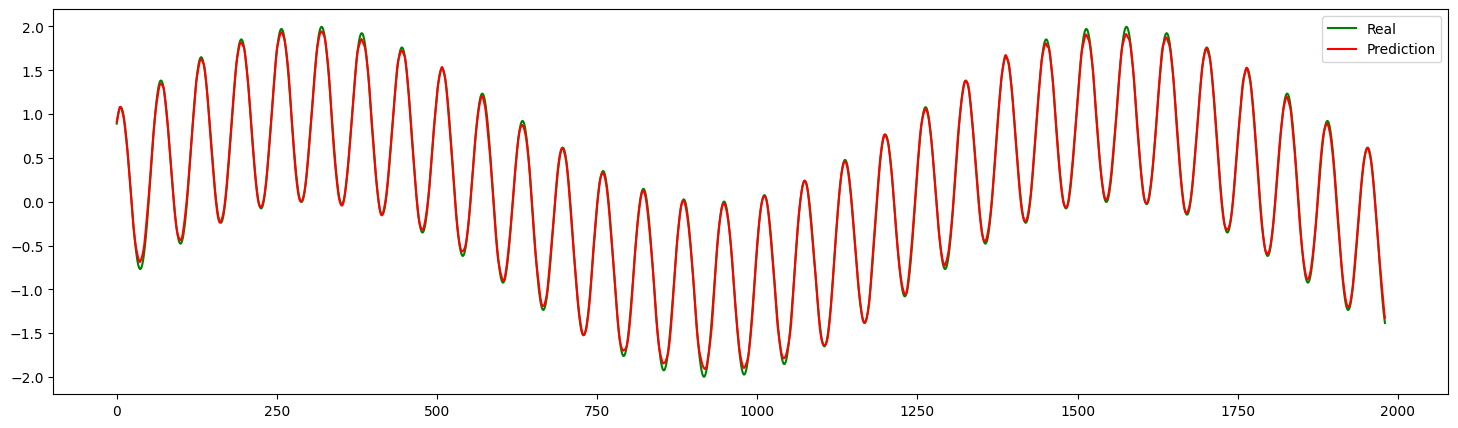

torch.Size([1981, 10, 1])


In [43]:
pred_y = inference_batch(model, enc_x, FORECAST_WINDOW, verbose=False)
plot_predictions(tgt_y[:,0], pred_y.detach().numpy()[:,0])
print(pred_y.shape)

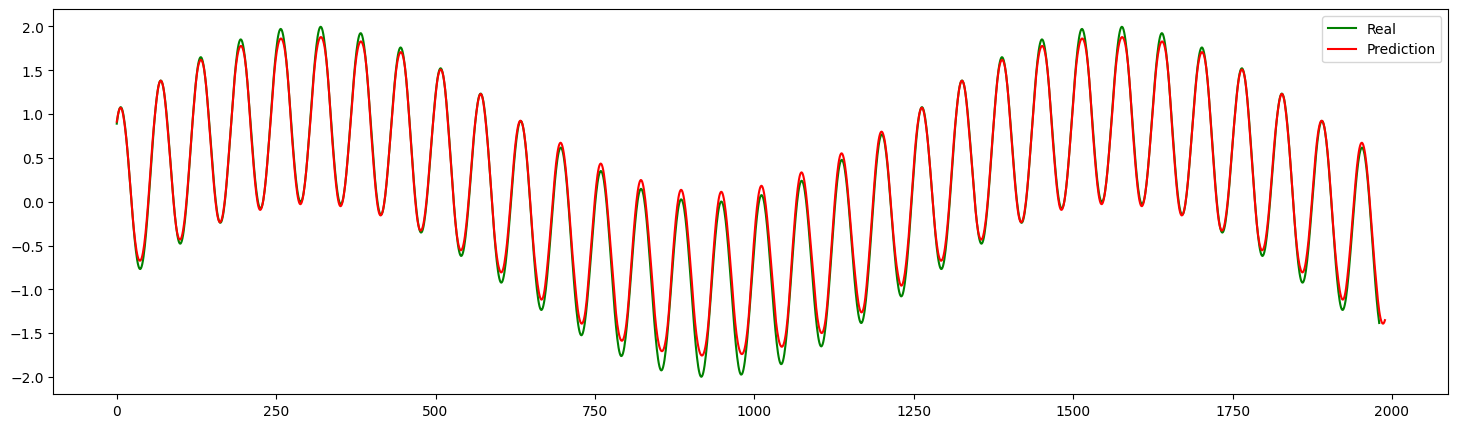

In [39]:
pred_y = inference_flat_serie(model, data, verbose=False)
plot_predictions(tgt_y[:,0], pred_y)


In [35]:
data2 = torch.tensor(data.numpy().copy(), dtype=torch.float32)[:12]
print('Serie:',data2)
enc_x2, dec_x2, tgt_y2 = make_batches(data2, INPUT_LEN, 1)
print('batches',enc_x2.shape)
print('Encoder input:',enc_x2.squeeze())
enc_x2[0,:,0] = 1000000 # modificar informacoes do batch anterior nao deveria modificar o output do proximo batch
print(enc_x2.shape)
FORECAST_WINDOW = 1
pred_y = inference_batch(model, enc_x2, FORECAST_WINDOW, verbose=False)
pred_y.detach().numpy()

Serie: tensor([0.0000, 0.1048, 0.2087, 0.3105, 0.4094, 0.5044, 0.5946, 0.6792, 0.7573,
        0.8283, 0.8915, 0.9462])
batches torch.Size([2, 10, 1])
Encoder input: tensor([[0.0000, 0.1048, 0.2087, 0.3105, 0.4094, 0.5044, 0.5946, 0.6792, 0.7573,
         0.8283],
        [0.1048, 0.2087, 0.3105, 0.4094, 0.5044, 0.5946, 0.6792, 0.7573, 0.8283,
         0.8915]])
torch.Size([2, 10, 1])
torch.Size([2, 10, 1])


array([[[3.2144382 ]],

       [[0.95441115]]], dtype=float32)

In [36]:
data2 = torch.tensor(data.numpy().copy(), dtype=torch.float32)[:12]
print('Serie:',data2)
FORECAST_WINDOW = 1
pred_y = inference_flat_serie(model, data2, FORECAST_WINDOW)
pred_y

Serie: tensor([0.0000, 0.1048, 0.2087, 0.3105, 0.4094, 0.5044, 0.5946, 0.6792, 0.7573,
        0.8283, 0.8915, 0.9462])
#3.0) input: torch.Size([1, 10, 1]) | decoder_input: torch.Size([1, 1, 1]) | pred_y: torch.Size([1, 1, 1])
#3.1) input: torch.Size([1, 10, 1]) | decoder_input: torch.Size([1, 1, 1]) | pred_y: torch.Size([1, 1, 1])


array([0.9138886, 0.9592047], dtype=float32)

## Assert

In [136]:
data2 = torch.tensor(data.numpy().copy(), dtype=torch.float32)[:13]
enc_x2, _, tgt_y2 = make_batches(data2, INPUT_LEN, 1)
print('Num of batches:', enc_x2.shape[0])
# enc_x2[2,:,:] = 1000000 # modificar informacoes do batch anterior nao deveria modificar o output do proximo batch
# enc_x2[2,:,:] = 1000000 # modificar informacoes do batch anterior nao deveria modificar o output do proximo batch

print(enc_x2.shape)
FORECAST_WINDOW = 1
pred_y = inference_batch(model, enc_x2, FORECAST_WINDOW, verbose=False)
pred_y.detach().numpy()

Num of batches: 3
torch.Size([3, 10, 1])
torch.Size([3, 10, 1])


array([[[0.73780143]],

       [[0.8286234 ]],

       [[0.91800517]]], dtype=float32)

In [143]:
data2 = torch.tensor(data.numpy().copy(), dtype=torch.float32)[:13]
enc_x2, _, tgt_y2 = make_batches(data2, INPUT_LEN, 1)
print('Num of batches:', enc_x2.shape[0])
# enc_x2[0,:,:] = 1000000 # modificar informacoes do batch anterior nao deveria modificar o output do proximo batch
# enc_x2[2,:,:] = 1000000 # modificar informacoes do batch anterior nao deveria modificar o output do proximo batch
data2[-1] = -10000
print(enc_x2.shape)
FORECAST_WINDOW = 1
pred_y = inference_flat_serie(model, data2, verbose=False)
pred_y#.detach().numpy()


Num of batches: 3
torch.Size([3, 10, 1])


array([0.16898002, 0.24145067, 0.8578568 ], dtype=float32)

In [ ]:
epochs = 10
forecast_window = 48 # supposing you're forecasting 48 hours ahead
enc_seq_len = 168 # supposing you want the model to base its forecasts on the previous 7 days of data
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
# Iterate over all epochs
for epoch in range(epochs):
    # Iterate over all (x,y) pairs in training dataloader
    for i, (src, tgt, tgt_y) in enumerate(training_dataloader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Generate masks
        tgt_mask = generate_square_subsequent_mask(
            dim1=forecast_window,
            dim2=forecast_window
            )

        src_mask = generate_square_subsequent_mask(
            dim1=forecast_window,
            dim2=enc_seq_len
            )
        # Make forecasts
        prediction = model(src, tgt, src_mask, tgt_mask)

        # Compute and backprop loss
        loss = criterion(tgt_y, prediction)

        loss.backward()

        # Take optimizer step
        optimizer.step()


    # Iterate over all (x,y) pairs in validation dataloader
    model.eval()

In [ ]:
batch_size = 2
time_steps = 10
in_features = 1
d_model = 512
torch.manual_seed(0); np.random.seed(0)
with torch.no_grad():
    x = torch.tensor(np.random.randn(batch_size, time_steps, in_features),dtype=torch.float32)
    layer = nn.Linear(in_features, d_model)

    y = layer(x)
    print(x.shape,'-->',y.shape)
    print(y.sum())


torch.Size([2, 10, 1]) --> torch.Size([2, 10, 512])
tensor(16.6356)
